# Dissolving, clipping, exploding rows

* What is the desired and expected behavior going from `all_bus` to `shape_dissolve` to `major_bus_stops_working` to `major_bus_stops`?
* What is the set of columns / unit of analysis in each stage?
* Knowns:
    * `all_bus` is at the `hqta_segment_id` level, which are still these 1,250 m segments associated with a `stop_id`
    * `shape_dissolve` aggregates up to `shape_id`....but if the columns are kept, it will automatically only keep the first one. If `stop_id` is kept, then across that entire bus route (`shape_id`), it will only have 1 `stop_id`, what that actual `stop_id` could be pretty far away. Is this expected / desired?
    * `major_bus_stops` is at the `stop_id` level


In [1]:
import dask.dataframe as dd
import dask_geopandas
import geopandas as gpd
import pandas as pd

import B1_bus_corridors as bus_corridors
import C1_prep_for_clipping as C1

from A1_rail_ferry_brt import analysis_date
from utilities import GCS_FILE_PATH
from shared_utils import rt_utils

date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
itp_id = 182
metro_route = "720"

## `all_bus`

In [3]:
all_bus = gpd.read_parquet(
    f"{bus_corridors.TEST_GCS_FILE_PATH}intermediate/all_bus.parquet")

all_bus = all_bus[(all_bus.calitp_itp_id==itp_id) & 
                  (all_bus.shape_id.str.startswith(metro_route))]

In [4]:
all_bus

,calitp_itp_id,stop_id,hqta_segment_id,segment_sequence,calitp_url_number,shape_id,geometry,am_max_trips,pm_max_trips,hq_transit_corr
7685,182,16704,298894490,15,0,7201273_FEB22,"POLYGON ((145631.640 -437486.239, 145453.522 -...",15,15,True
7745,182,16664,381485187,11,0,7201273_FEB22,"POLYGON ((150889.827 -437881.983, 150889.058 -...",16,15,True
7760,182,104702,409372849,19,0,7201273_FEB22,"POLYGON ((141587.396 -439971.508, 141588.451 -...",8,7,True
7993,182,7371,816568292,3,0,7201273_FEB22,"POLYGON ((159974.969 -438533.984, 159947.610 -...",21,22,True
8074,182,8393,935728125,7,0,7201273_FEB22,"POLYGON ((155892.476 -437983.386, 155856.715 -...",16,18,True
8132,182,8377,1032868672,21,0,7201273_FEB22,"POLYGON ((140147.304 -441555.815, 140104.199 -...",13,7,True
8161,182,5775,1086399339,6,0,7201273_FEB22,"POLYGON ((157127.315 -437954.813, 157127.028 -...",30,31,True
8244,182,15688,1202513778,2,0,7201273_FEB22,"POLYGON ((161515.943 -439415.302, 161515.866 -...",46,45,True
8271,182,8383,1251435478,20,0,7201273_FEB22,"POLYGON ((141041.097 -440657.571, 140996.434 -...",12,7,True
8307,182,38,1308272591,24,0,7201273_FEB22,"POLYGON ((139528.377 -443542.928, 139591.065 -...",20,13,True


In [5]:
def stats(df):
    print(f"# rows: {len(df)}")
    print(f"# unique stops: {df.stop_id.nunique()}")
    print(f"# unique hqta_segment_id: {df.hqta_segment_id.nunique()}")
    
    map1 = df.plot(column="shape_id", figsize=(10, 10), cmap="tab10"
                  ).set_title("shape_id")
    map2 = df.plot(column="hqta_segment_id", figsize=(10, 10), cmap="tab10"
                  ).set_title("hqta_segment_id")
    
    print(map1)
    print(map2)

# rows: 25
# unique stops: 23
# unique hqta_segment_id: 25
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'hqta_segment_id')


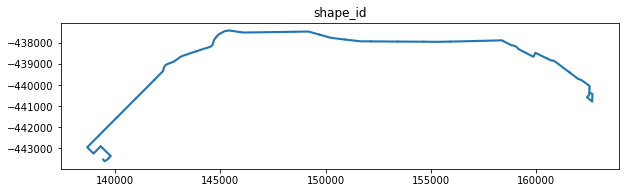

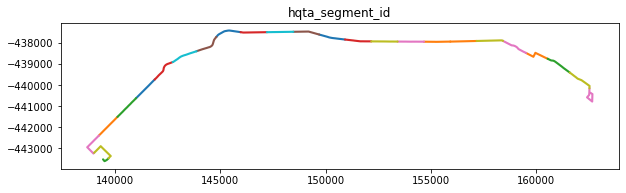

In [6]:
stats(all_bus)

## `shape_dissolve`

In this dissolve, do we actually want to have lost the `hqta_segment_id`? Now `stop_id` isn't linked to that segment. The segment, which is much shorter, is more closely associated with where the actual stop falls. In the dissolve, if `stop_id` is kept as a column, then the first stop_id for that `shape_id`. If only 1 `stop_id` is a stand-in for the entire `shape_id`, that could mean the actual physical location of the stop is far from the `geometry` associated with `shape_id`.

2 possible desired behaviors:
* We want to find where 2 bus routes intersect, and keep that geometry, and then associate that little clipped/intersecting area to a stop? `geometry` -- the clipped/intersecting area.
* We can do a spatial join and see whether that `hqta_segment_id`-`stop_id` does intersect with another `hqta_segment_id`-`stop_id` (same operator or different operator). If it does intersect, then we keep it. `geometry` -- the 1,250 m hqta segment length. 

In [7]:
shape_dissolve = gpd.read_parquet(
    f"{bus_corridors.TEST_GCS_FILE_PATH}intermediate/shape_dissolve.parquet")

shape_dissolve = shape_dissolve[(shape_dissolve.calitp_itp_id==itp_id) & 
                                (shape_dissolve.shape_id.str.startswith(metro_route))
                               ]

shape_dissolve

,calitp_itp_id,shape_id,hq_transit_corr,geometry,stop_id,hqta_segment_id,segment_sequence,calitp_url_number,am_max_trips,pm_max_trips,area
1417,182,7201273_FEB22,True,"MULTIPOLYGON (((139663.064 -443439.549, 139671...",16704,298894490,15,0,15,15,2.914129e+06


# rows: 1
# unique stops: 1
# unique hqta_segment_id: 1
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'hqta_segment_id')


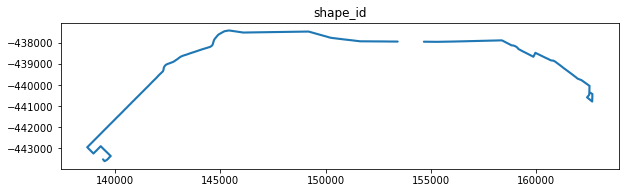

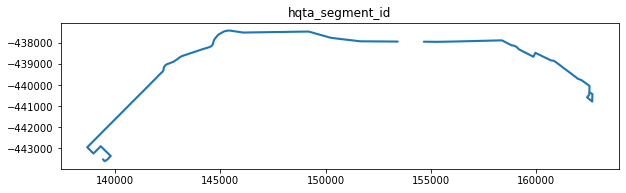

In [8]:
stats(shape_dissolve)

## `major_bus_stops_working`

In [9]:
working = gpd.read_parquet(f"{GCS_FILE_PATH}major_bus_stops_working.parquet")
working = working[(working.calitp_itp_id == itp_id) & 
                  (working.shape_id.str.startswith("700"))]

working

,hq_transit_corr,shape_id,calitp_itp_id,geometry,calitp_url_number,hqta_segment_id,segment_sequence,stop_id,am_max_trips,pm_max_trips,departure_hour,n,hqta_type,route_type
3816,True,700290_FEB22,182,"MULTIPOLYGON (((161158.925 -439002.405, 161160...",0,3785277923,1,13560,53.0,51.0,NaN,NaN,hq_transit_corr,3
3817,True,700292_FEB22,182,"MULTIPOLYGON (((180244.118 -436298.385, 180244...",0,3569153544,0,6535,34.0,35.0,NaN,NaN,hq_transit_corr,3


# rows: 2
# unique stops: 2
# unique hqta_segment_id: 2
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'hqta_segment_id')


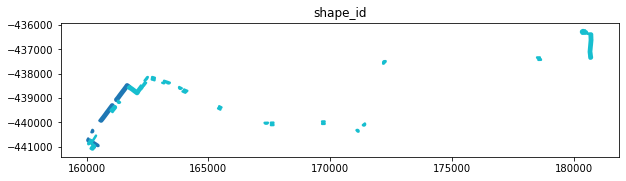

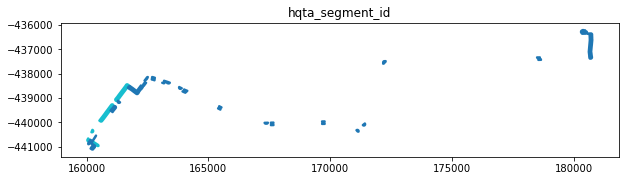

In [10]:
stats(working)

## `major_bus_stops`

In [11]:
stops = gpd.read_parquet(f"{GCS_FILE_PATH}major_bus_stops.parquet")

stops = stops[(stops.calitp_itp_id==182) & 
              (stops.stop_id.isin(working.stop_id))]
stops.head()

,calitp_itp_id,stop_id,geometry,hqta_type
2195,182,13560,"POLYGON ((160164.678 -440366.591, 160169.107 -...",major_transit_stop
2196,182,6535,"POLYGON ((178495.863 -437424.231, 178495.191 -...",major_transit_stop
2197,182,6535,"POLYGON ((172123.076 -437581.854, 172123.050 -...",major_transit_stop
2198,182,6535,"POLYGON ((171350.044 -440044.880, 171350.182 -...",major_transit_stop
2199,182,6535,"POLYGON ((171162.531 -440433.567, 171157.699 -...",major_transit_stop


In [12]:
print(f"# rows: {len(stops)}")
print(f"# unique stops: {stops.stop_id.nunique()}")

# rows: 14
# unique stops: 2


Text(0.5, 1.0, 'stop_id')

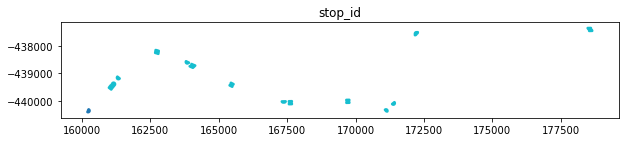

In [13]:
stops.plot(column="stop_id", figsize=(10, 10), cmap="tab10"
          ).set_title("stop_id")

Text(0.5, 1.0, 'index')

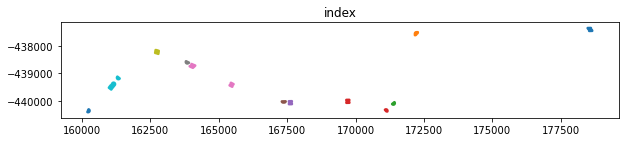

In [14]:
stops = stops.assign(obs = stops.index)
stops.plot(column="obs", figsize=(10, 10), cmap="tab10"
          ).set_title("index")